# Определение оттока клиентов фитнес-центра

___
## Описание проекта
___
Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами, а именно определение и прогнозирование оттока клиентов. 
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Если клиент посетил спортзал всего несколько раз, а потом пропал — скорее всего, он не вернётся. Чтобы минимизировать отток необходимо провести анализ и подготовить план действий по удержанию клиентов.

___
## Цель исследования
___
 - спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
 - сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
 - проанализировать основные признаки, наиболее сильно влияющие на отток;
 - сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами, такие как:
 
   - выделить целевые группы клиентов;
   - предложить меры по снижению оттока;
   - определить другие особенности взаимодействия с клиентами.

## Загрузка данных и проведение исследовательского анализа

### Подготовка данных

Начнем исследование со знакомства с данными, прочитаем их и запишем в переменную *data*, затем познакомимся с ними с помощью специально подготовленной функции. Также сразу установим и импортируем необходимые библиотеки для работы.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
pd.set_option("max_colwidth", 150)

In [2]:
cust_data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
# Функция приводит названия столбцов к "змеиному" регистру и выводит информацию о данных
# Функция может принимать несколько аргументов, поэтому используется синтаксис *args

def info(*datasets):
    for frame in datasets:
        frame.columns = [x.lower().strip().replace(' ', '_') for x in frame.columns.values]
        frame.info()
        display(frame.head())

In [4]:
info(cust_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Видим, что пропусков нет, проверим данные на дубликаты.

In [5]:
cust_data.duplicated().sum()

0

Дубликатов также не наблюдаем. 

### Исследовательский анализ

Теперь посмотрим на основные характеристики данных с помощью метода *describe()*. Оценим средние значения, стандартное отклонение, процентили и экстремумы (минимумы и максимумы).

In [6]:
cust_data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Gender** - признак имеет два значения категорий 0 или 1, имеет среднее значение чуть более 0.5, что говорит о том, что клиентов определенного пола немного больше.

**Near_location** - имеет значения 0 или 1, в данном случае видим, что намного больше клиентов проживает в районе фитнес-центра.

**Partner** - имеет значения 0 или 1, видим, что немного менее половины клиентов являются сотрудниками компаний-партнеров фитнес-центра.

**Promo_friends** - значения 0 или 1, тех, кто пришел по программе акции меньшинство, две трети пришли не по акции.

**Phone** - значения 0 или 1, видим, что подавляющее большинство оставляет свой номер телефона.

**Group_visits** - значения 0 или 1, по данным видим, что немного больше тех клиентов, кто не посещал групповые занятия.

**Churn** - факт того, что клиент попал в отток, в данном случае видим, что большинство клиентов в этом месяце не попали в отток, но все же немало тех, кто попал.

Теперь рассмотрим оставшиеся "небулевские признаки", построим графики распределения для каждого из них в разрезе тех клиентов, кто остался и тех, кто попал в отток в рассматриваемом месяце. Затем посмотрим еще раз на среднии значения в том же разделении на две группы.

Для начала создадим два соответствующих среза, для тех, кто в оттоке и кто нет.

In [7]:
cust_out_club = cust_data[cust_data['churn'] == 1]
cust_in_club = cust_data[cust_data['churn'] == 0]

Теперь построим графики распределения "небулевских" признаков для каждой из созданных групп, воспользуемся *kdeplot* библиотеки *seaborn*.

In [8]:
# Создаем список интересующих нас колонок для использования в цикле

list_columns = ['contract_period', 
                'age', 
                'avg_additional_charges_total',  
                'lifetime', 
                'avg_class_frequency_total', 
                ]

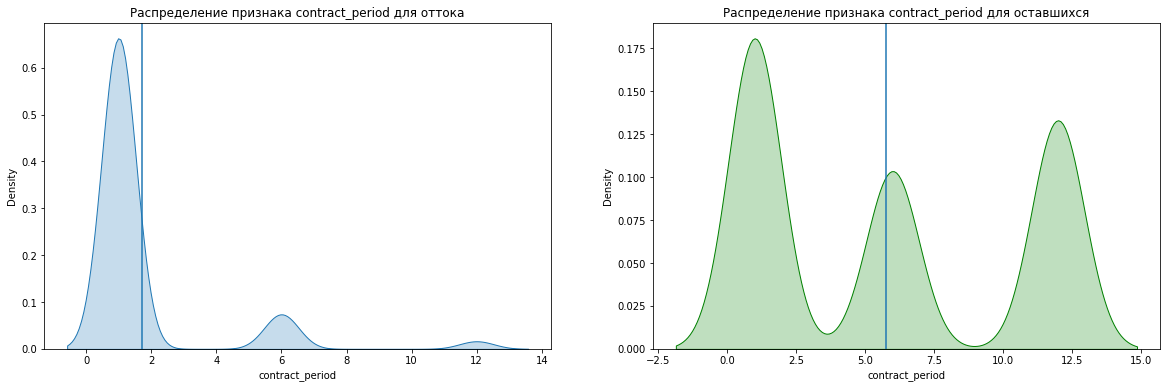

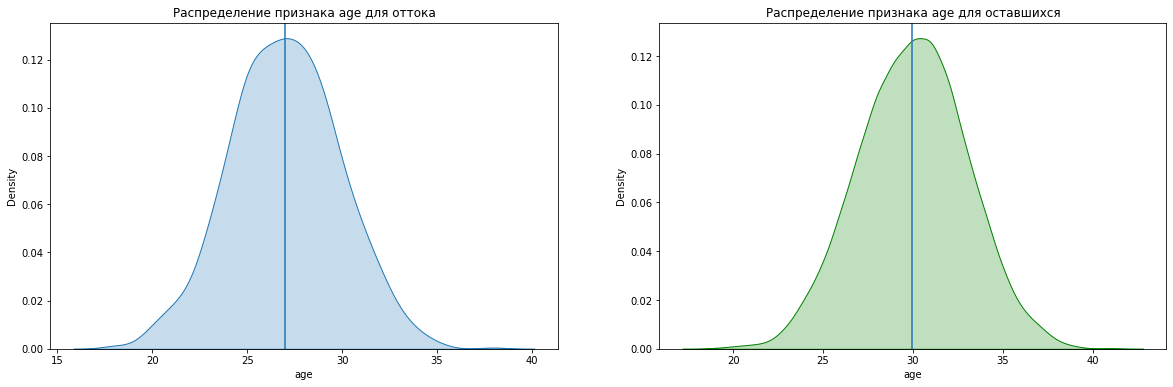

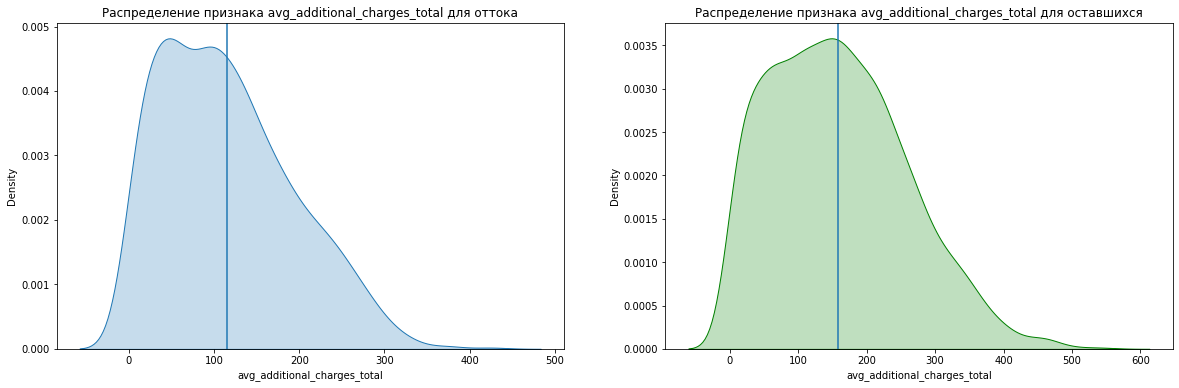

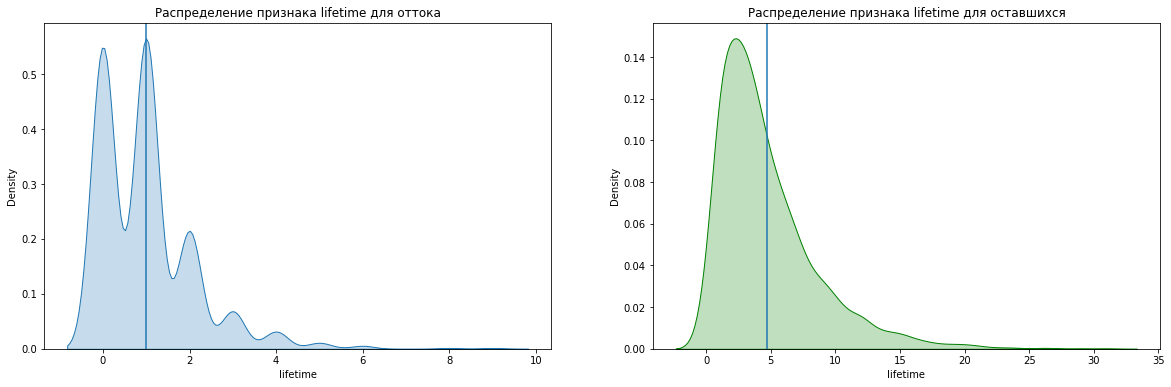

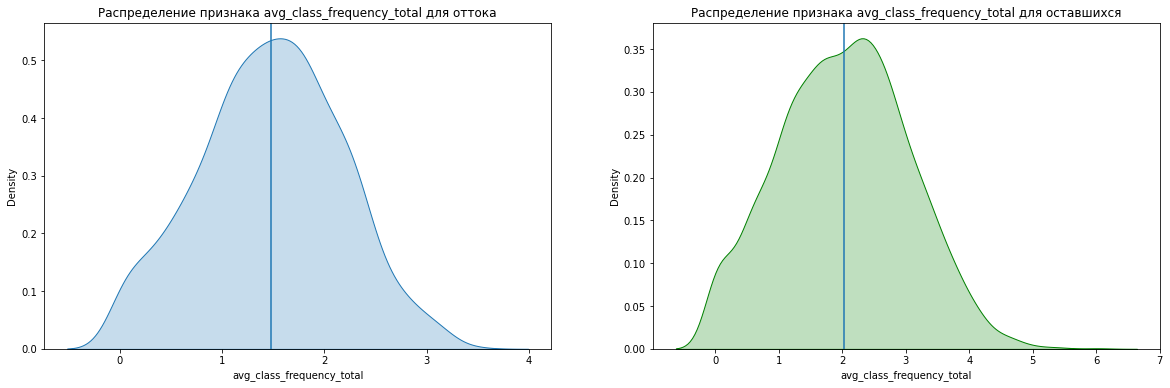

In [9]:
# Получившийся цикл выводит попарно графики распределения каждого из признаков списка, соответственно для тех клиентов, кто
# оказался в оттоке и для оставшихся клиентов

for c in list_columns:
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.title('Распределение признака {} для оттока'.format(c))
    sns.kdeplot(cust_out_club[c], shade=True)
    plt.axvline(cust_out_club[c].mean())
    
    plt.subplot(1, 2, 2)
    plt.title('Распределение признака {} для оставшихся'.format(c))
    sns.kdeplot(cust_in_club[c], shade=True, color='green')
    plt.axvline(cust_in_club[c].mean())
    plt.show()

Рассмотрим все признаки по порядку, начнем с **contract_period** - длительность текущего абонемента. Видим, что для клиентов оттока подавляющее большинство приобретали краткосрочный абонемент на 1 месяц, вероятно такие клиенты изначально не всерьез планировали долго ходить в спортзал. Для оставшихся клиентов значительная доля приобретали в том числе абонемент на 6 и 12 месяцев.

**age** - возраст обоих групп клиентов распределен почти одинаково, но все же распределение для клиентов оттока имеет небольшое смещение в более молодую сторону (к меньшему возрасту). Вероятно более старшие клиенты более состоятельны и планируют свои посещения более основательно.

**avg_additional_charges_total** - суммарная выручка от других услуг фитнес центра. В данном случае распределения также почти одинаковы, но для оставшихся клиентов оно значительно смещается вправо - в строну больших значений. Скорее всего далее на графике сравнения средних величин признаков мы увидим заметную разницу, опять же это вполне ожидаемо, так как те клиенты, которые ходят регулярно с большей вероятностью воспользуются и другими услугами.

**month_to_end_contract** - срок до окончания текущего действующего абонемента. Здесь видим почти такую же ситуацию, как и в случае с признаком **contract_period**. Это вполне логично, так как ненадежные клиенты в прошлый раз с большей вероятностью купили самый краткосрочный абонемент. Из-за такой разницы этот признак может оказать очень существенное влияние на прогноз целевой переменной.

**lifetime** - для клиентов оттока видим очень неравномерное распределение, что может быть связано с большим оттоком именно в первый месяц ("яма" на графике между двумя вершинами)

**avg_class_frequency_total** - средняя частота посещения в неделю. Для этого признака распределение для клиентов оттока располагается в основном внутри интервала от 1 до 3 дней, в то время как для оставшихся клиентов средняя частота посещения немного выше.

**avg_class_frequency_current_month** - средняя частота посещений в неделю за предыдущий месяц. Здесь снова видим тот факт, что оставшиеся клиенты более часто посещают спортзал.

Теперь сравним средние значения двух групп, оставшихся и клиентов оттока. Для этого для определенных ранее срезов вызывем метод *describe()* и создадим два датафрейма с единственной строкой средних значений.

Выведем на график получившиеся значения в виде линейного графика с помощью *lineplot*. 

In [10]:
desc_for_out = cust_out_club.describe()
desc_for_in = cust_in_club.describe()

mean_for_out = desc_for_out.loc['mean']
mean_for_in = desc_for_in.loc['mean']

mean_for_out = pd.DataFrame(mean_for_out)
mean_for_in = pd.DataFrame(mean_for_in)

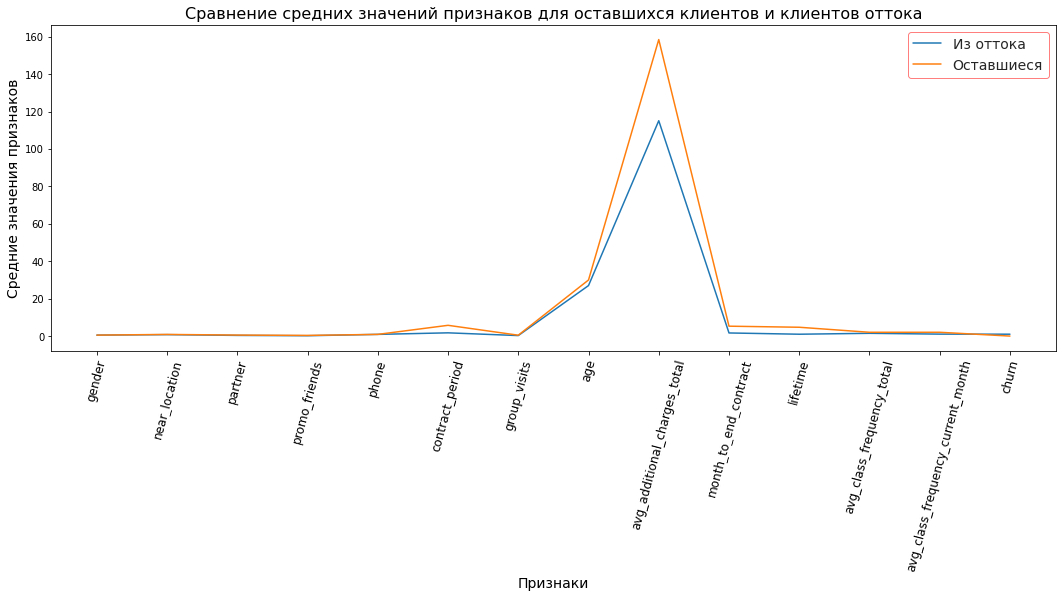

In [11]:
plt.figure(figsize=(18, 6))
plt.title('Сравнение средних значений признаков для оставшихся клиентов и клиентов оттока', fontsize=16)
sns.set_style('darkgrid')
sns.lineplot(x=mean_for_out.index, y='mean', data=mean_for_out, label='Из оттока')
sns.lineplot(x=mean_for_in.index, y='mean', data=mean_for_in, label='Оставшиеся')
plt.xlabel('Признаки', fontsize=14)
plt.ylabel('Средние значения признаков', fontsize=14)
plt.xticks(fontsize=12, rotation = 75)
plt.legend(fontsize=14, framealpha=0.5, facecolor='w', edgecolor='r')
plt.show()

По графику можно сделать аналогичные выводы, по таким показателям длительность абонемента, возраст, суммарная выручка от других услуг фитнесцентра, срок до окончания абонемента и лайфтайм клиента средние значения значительно выше. Также еще раз выведем средние значения всех признаков в виде сводной таблицы. 

In [13]:
pivot_feature = mean_for_out.merge(mean_for_in, left_index=True, right_index=True, suffixes = ('_out', '_in'))
pivot_feature

,mean_out,mean_in
gender,0.510839,0.510037
near_location,0.768143,0.873086
partner,0.355325,0.534195
promo_friends,0.183789,0.353522
phone,0.902922,0.903709
contract_period,1.728558,5.747193
group_visits,0.268615,0.464103
age,26.989632,29.976523
avg_additional_charges_total,115.082899,158.445715
month_to_end_contract,1.662582,5.283089


Теперь построим матрицу корреляций и отобразим ее в виде тепловой карты *heatmap* с подписями данных. Саму матрицу создадим методом *corr()*.

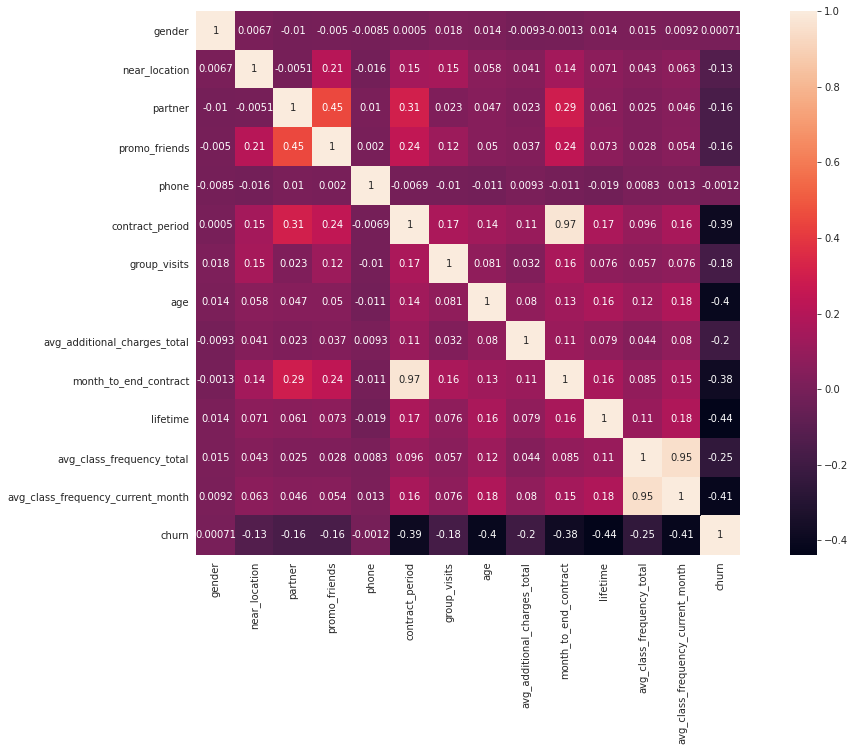

In [14]:
feature_corr = cust_data.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(feature_corr, annot=True, square=True)  
plt.show()

Ярко выраженные корреляции наблюдаем для признаков текущей и общей частоты посещаемости, также между количеством месяцев до окончания абонемента и длительностью текущего абонемента. Удалим признаки **month_to_end_contract** и **avg_class_frequency_current_month**.

Наша целевая переменная churn также заметно коррелирует с половиной признаков в обратной зависимости, где наибольшего значения достигает корреляция факта оттока с лайфтаймом клиента, иными словами, чем дольше клиент посещает фитнес-центр, тем сильнее снижается вероятность его ухода в рассматриваемом месяце. 

In [15]:
cust_data = cust_data.drop(columns=['month_to_end_contract', 'avg_class_frequency_current_month'])

## Модель прогнозирования оттока клиентов

Теперь построим модель бинарной классификации клиентов. Целевым признаком в данном случае будет являться факт оттока клиентов. Для начала разделим признаки и целевую признак и запишем в разные переменные, затем получившиеся вектор и матрицу разделим на обучающую и валидационную метрику в соотношении 80/20 с помощью функции *train_test_split()*.

In [16]:
X = cust_data.drop(columns=['churn'])
y = cust_data['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Теперь обучим нашу модель на тестовой выборке, создадим объект класса *LogisticRegression()* для логистической регрессии и *RandomForestClassifier()* для случайного леса, укажем параметр random_state для воспроизводимости результатов. Также стандартизируем данные с помощью объекта класса *StandardScaler()*

In [17]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)


# Задаем алгоритм для логистической регресии
model_logistic = LogisticRegression(solver='liblinear', random_state=0)

# Обучаем модель
model_logistic.fit(X_train_st, y_train)



# Задаем модель для случайного леса, аргумент n_estimators = 100 задает число деревьев, на основании которых будет 
# строиться случайный лес
model_tree = RandomForestClassifier(n_estimators = 100, random_state=0)

# Обучаем модель 
model_tree.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

Мы получили обученные модели двух алгоритмов, теперь можно воспользоваться ими для того, чтобы сделать прогноз. Сделаем это с помощью функций *predict* - для получения вектора со значениями классов и *predict_proba* - для вероятности принадлежности к классу.

Затем оценить метрики accuracy, precision и recall для обеих моделей на валидационной выборке, напишем функцию для вывода этих метрик.

In [18]:
logistic_predictions = model_logistic.predict(X_test_st)
logistic_probabilities = model_logistic.predict_proba(X_test_st)[:, 1]

tree_predictions = model_tree.predict(X_test)
tree_probabilities = model_tree.predict_proba(X_test)[:, 1]

In [19]:
# определим функцию, которая будет выводить наши метрики
def print_metrics(y_true, y_pred, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [20]:
# Выведем метрики для логистической регресии
print_metrics(y_test, logistic_predictions, title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81


In [21]:
# Выведем метрики для случайного леса
print_metrics(y_test, tree_predictions, title='Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.78
	Recall: 0.77


Получаем схожие результаты работы обоих алгоритмов, первая метрика показала более высокие результаты для логистической регресии, как и точность и полнота. Таким образом получаем, что модель логистической регресии показала себя немного лучше.

## Кластеризация клиентов

Проведем кластеризацию клиентов для выделения характерных особенностей каждой и полученных групп, в частности для определения доли клиентов оттока. Это поможет оценить, какие признаки стоит учитывать в большей степени при планировании дальнейшей работы фитнес-центра.

Для этого для начала стандартизируем данные, с помощью функции *linkage()* построим стандартизированную матрицу расстояний и отрисуем дендограмму, по которой сделаем предположение об оптимальном количестве кластеров.

In [22]:
# Стандартизируем данные 
x_sc = scaler.fit_transform(cust_data.drop(columns = ['churn']))

# Определяем функцию расстояния для получения матрицы расстояния
linked = linkage(x_sc, method = 'ward')

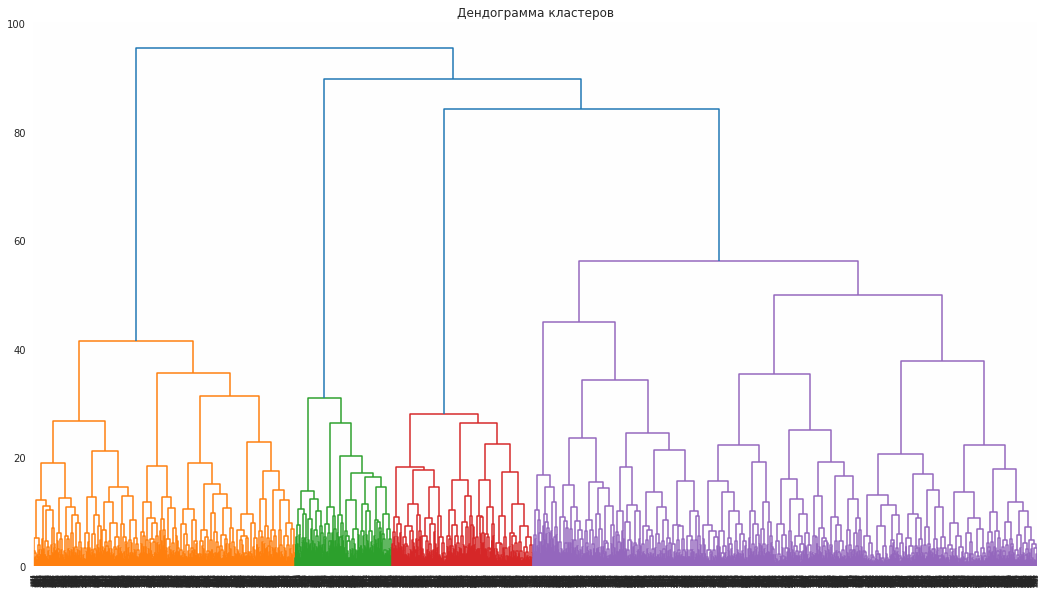

In [23]:
# Строим дендограмму
plt.figure(figsize=(18, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендограмма кластеров')
plt.show()

Видим, что в данном случае получилось предположительно 4 кластера клиентов.

Теперь обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Примем количество кластеров равным 5.

In [24]:
# Определяем модель k-means с числом кластеров 5
km = KMeans(n_clusters=5, random_state=0)
# В переменной labels будут храниться индексы предложенных алгоритмом групп
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле датасета
cust_data['clusters'] = labels

Теперь после того как в нашем датафрейме есть новый столбец с индексами кластеров мы можем сгруппировать данные по этим индексам и вывести в виде сводной таблицы. Агрегируем данные по среднему значению. Сделаем это и затем построим график средних значений в разбивке по кластерам аналогичный тому, который строли для средних значения в разбивке по *churn*. По таблице средних значений можно оценить "булевские" признаки. Также построим графики распределений для остальных признаков и оценим различия между кластерами.

In [25]:
mean_by_clusters = cust_data.groupby('clusters').agg('mean').T
mean_by_clusters

clusters,0,1,2,3,4
gender,0.499109,0.488571,0.505300,0.544202,0.523316
near_location,0.000000,0.995238,1.000000,1.000000,0.862694
partner,0.488414,0.955238,0.238516,0.250287,0.471503
promo_friends,0.076649,0.892381,0.059187,0.079219,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.032086,7.660952,2.819788,4.528129,4.777202
group_visits,0.235294,0.458095,0.000000,1.000000,0.427461
age,28.721925,29.543810,28.770318,29.536165,29.297927
avg_additional_charges_total,137.540009,155.861428,143.383993,148.088897,144.208179
lifetime,3.060606,4.380952,3.343640,3.761194,3.940415


По получившимся средним значениям видим, что выделяются 1 кластер (по большим средним значениям для некоторых признаков). Теперь построим распределение признаков по получившимся кластерам, сделаем это аналогично тому, как было проделано для получения распределения признаков в разбивке по клиентам оттока и оставшимся. Для начала создадим соответствующие срезы а затем выведем графики распределений с помощью цикла.

In [26]:
cust_0 = cust_data[cust_data['clusters'] == 0]
cust_1 = cust_data[cust_data['clusters'] == 1]
cust_2 = cust_data[cust_data['clusters'] == 2]
cust_3 = cust_data[cust_data['clusters'] == 3]
cust_4 = cust_data[cust_data['clusters'] == 4]

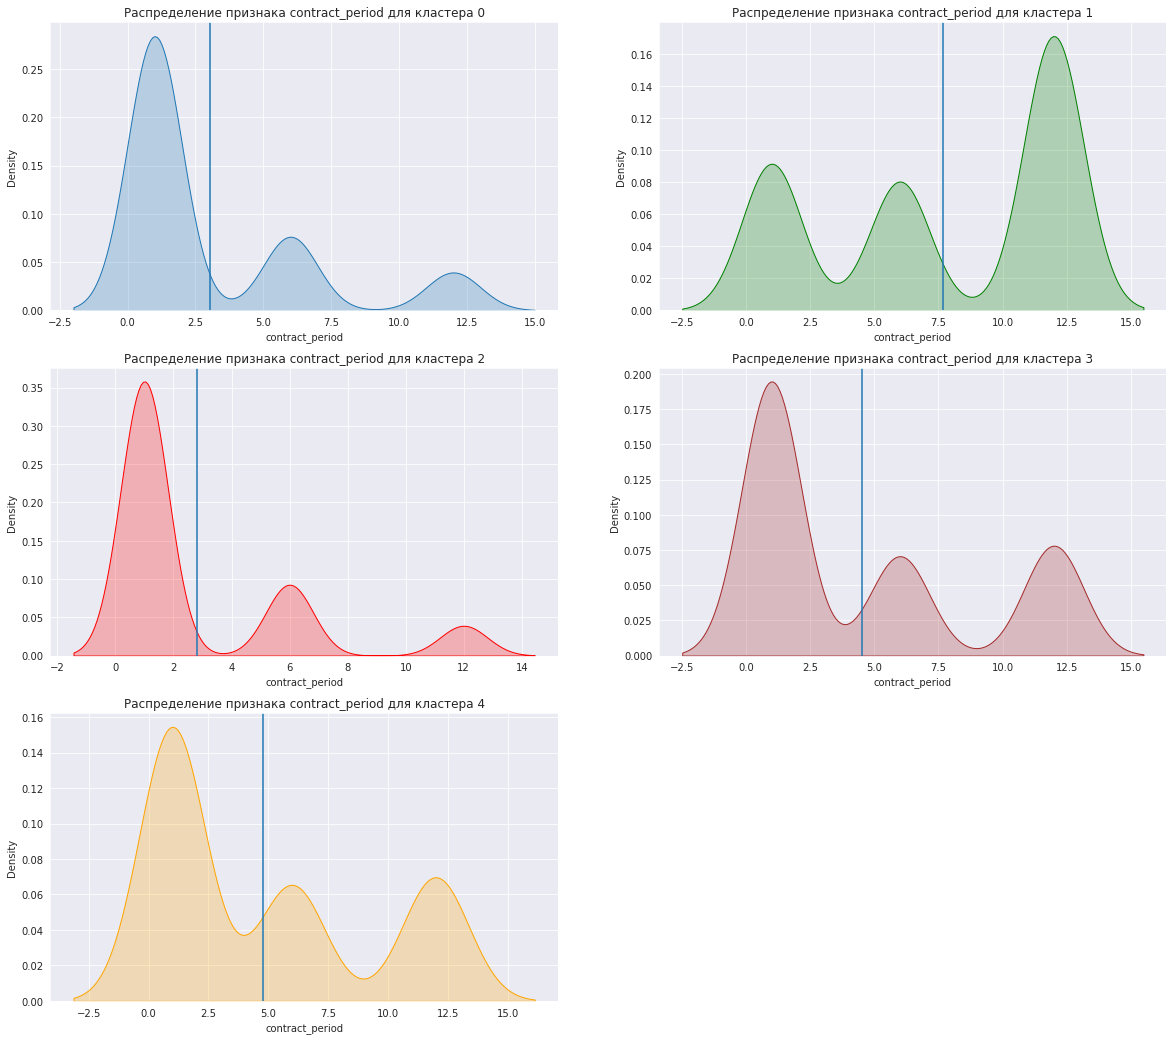

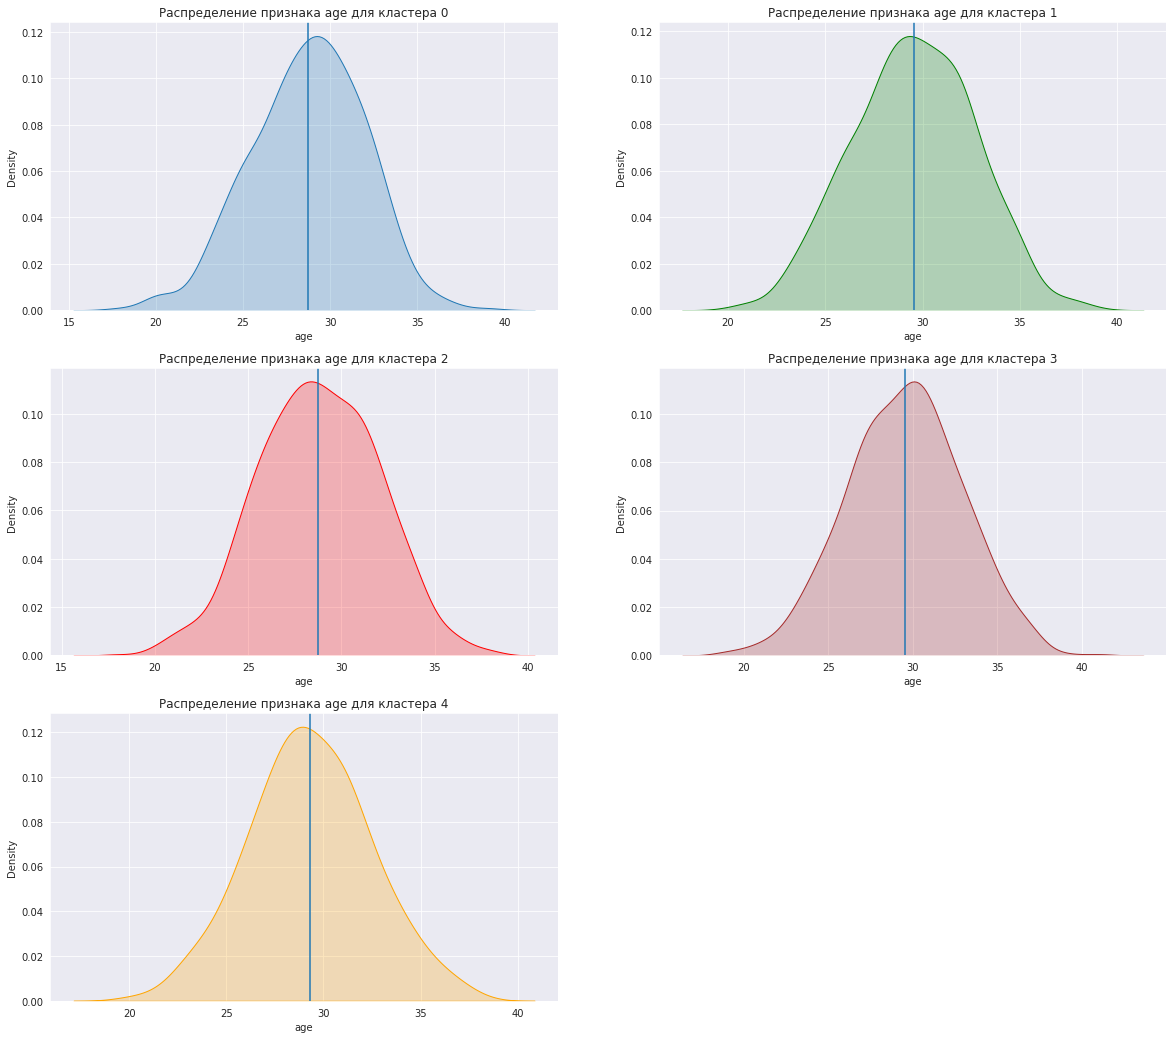

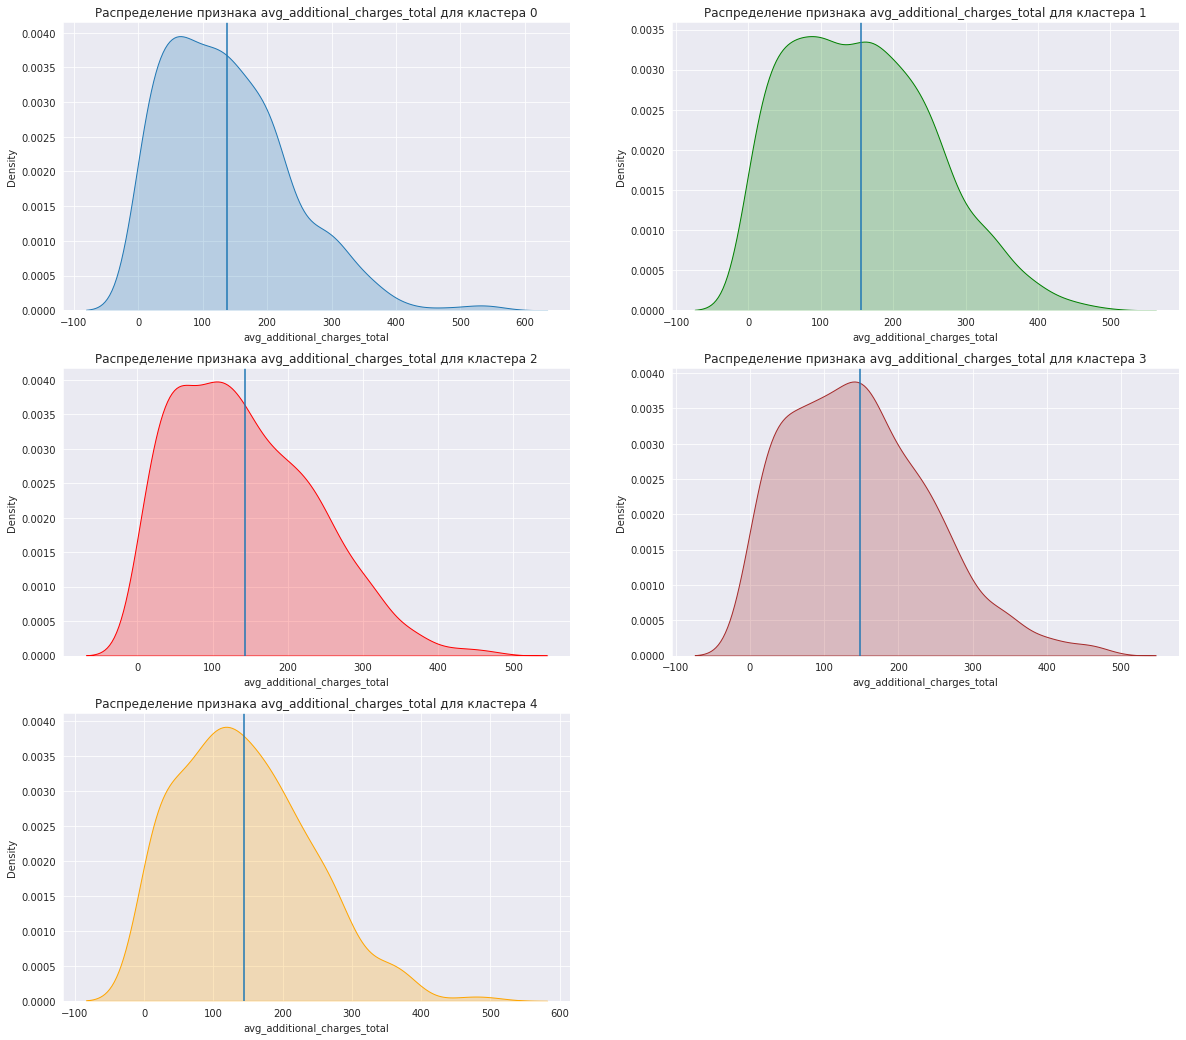

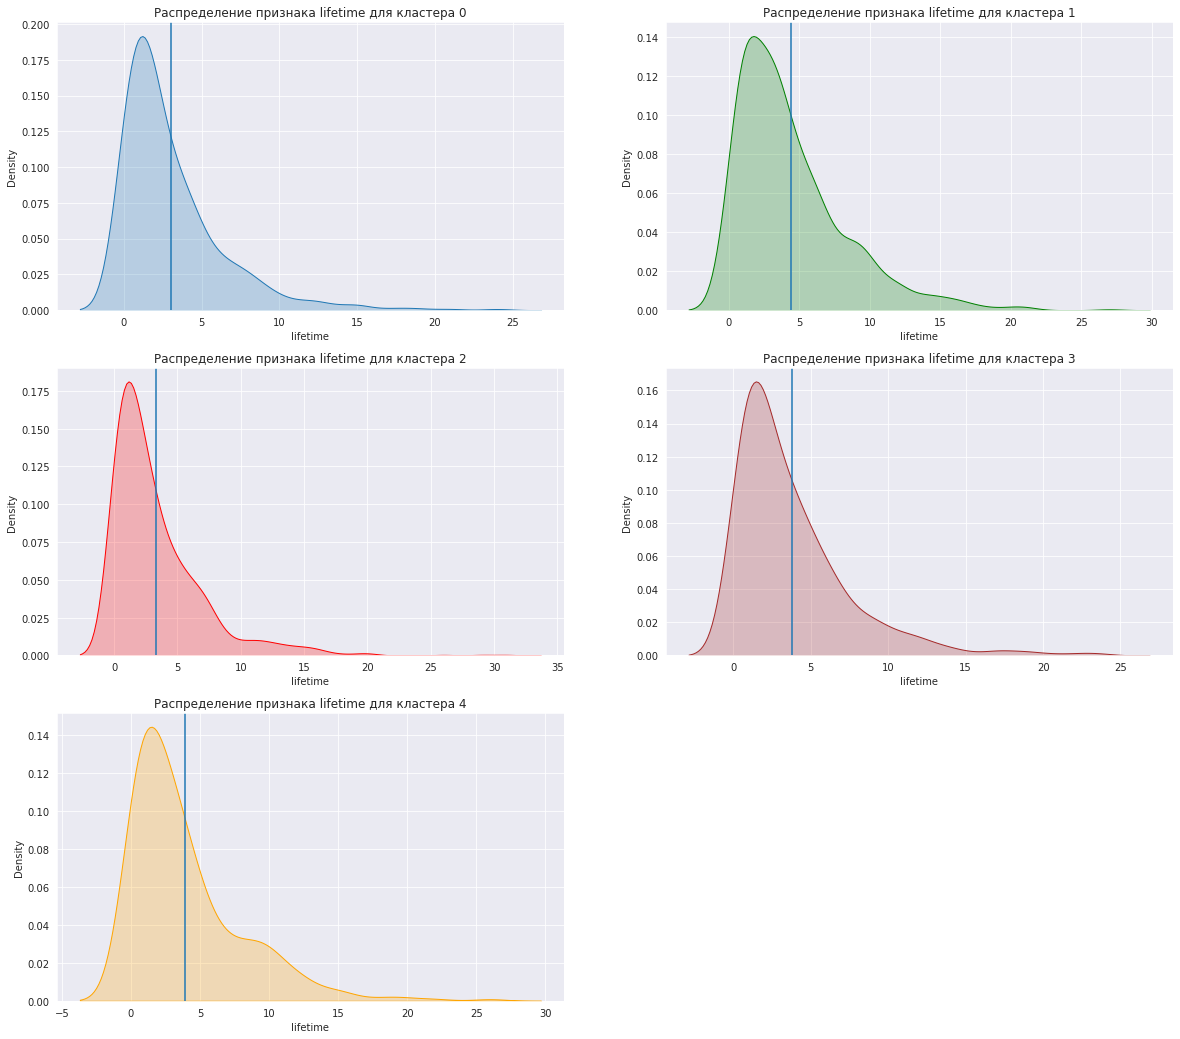

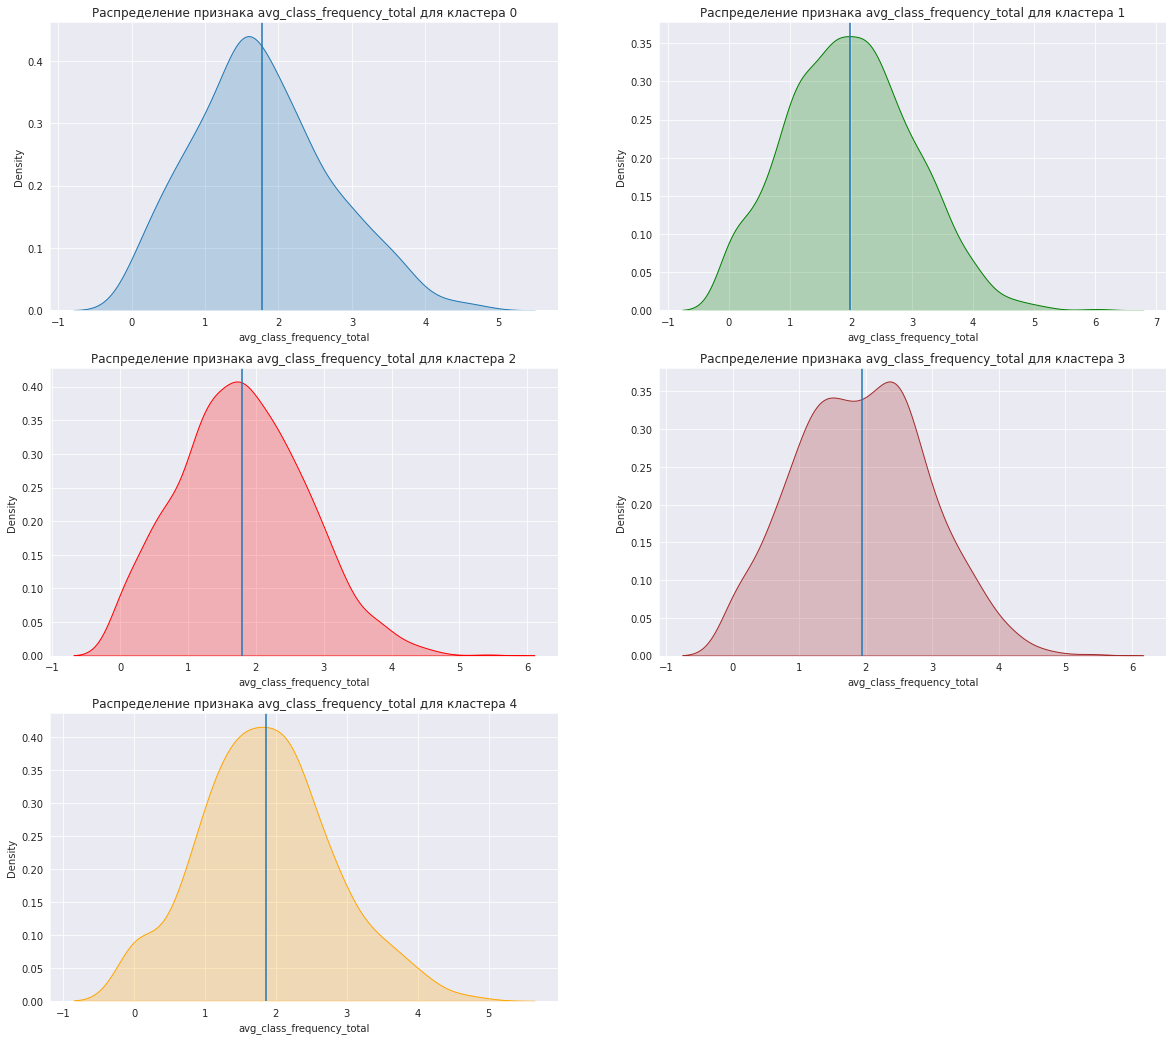

In [27]:
for c in list_columns:
    plt.figure(figsize=(20, 18))
    plt.subplot(3, 2, 1)
    plt.title('Распределение признака {} для кластера 0'.format(c))
    sns.kdeplot(cust_0[c], shade=True)
    plt.axvline(cust_0[c].mean())
    
    plt.subplot(3, 2, 2)
    plt.title('Распределение признака {} для кластера 1'.format(c))
    sns.kdeplot(cust_1[c], shade=True, color='green')
    plt.axvline(cust_1[c].mean())
    
    plt.subplot(3, 2, 3)
    plt.title('Распределение признака {} для кластера 2'.format(c))
    sns.kdeplot(cust_2[c], shade=True, color='red')
    plt.axvline(cust_2[c].mean())
    
    plt.subplot(3, 2, 4)
    plt.title('Распределение признака {} для кластера 3'.format(c))
    sns.kdeplot(cust_3[c], shade=True, color='brown')
    plt.axvline(cust_3[c].mean())
    
    plt.subplot(3, 2, 5)
    plt.title('Распределение признака {} для кластера 4'.format(c))
    sns.kdeplot(cust_4[c], shade=True, color='orange')
    plt.axvline(cust_4[c].mean())
    plt.show()

**contract_period** - длительность текущего абонемента. Схожие распределения для кластеров 3 и 4, а именно большего всего клиентов с краткосрочными абонементами, кластеры 0 и 2 практически не имеют клиентов с годовыми абонементами, в 1 кластер попали клиенты с длительными, преимущественно годовыми абонементами.

**age** - здесь в кластер 1 более всего попали старшие клиенты, а в кластер 3 наиболее молодые.

**avg_additional_charges_total** - суммарная выручка от других услуг фитнес центра. В данном случае в кластеры 1 и 3 попали более платежеспособные клиенты, кластер 2 и 0 менее платежеспособные. Это частично соотносится и с распределением по возрасту, чем старше клиенты, тем больше дополнительной выручки они приносят. 

**lifetime** - для 1 и 4 кластера распределения наиболее схожи, клиенты в них в среднем живут подольше.

**avg_class_frequency_total** - средняя частота посещения в неделю. И снова для 1 и 3 кластеров наиболее высокая в среднем частота посещения, для 0 кластера наименьшая.

Таким образом, на данный момент можно сказать, что клиенты кластеров 1 и 3 в целом смотряться лучше остальных, они чаще других покупают длительные абонементы, приносят больше дополнительной прибыли и чаще ходят в спортзал. Посмотрим какова будет величина доли оттока у этих кластеров в сравнении с остальными.

Для каждого кластера посчитаем долю оттока клиентов, а также же размер кластера, воспользуемся группировкой. Предствим полученные значения в виде столбчатой диаграммы. Так как столбец churn принимает значения только 0 или 1, величина среднего значения для каждого кластера фактически и будет величиной соотношения, чем ближе это число к 0, тем больше нулевых значений и наоборот, значит низкое значение означает малую долю оттока.

In [28]:
churn_ratio = pd.DataFrame(cust_data.groupby('clusters')['churn'].agg('mean').reset_index())
churn_size = pd.DataFrame(cust_data.groupby('clusters')['churn'].agg('count').reset_index())
churn_feature = churn_ratio.merge(churn_size, on='clusters', suffixes = ('_ratio', '_size'))
churn_feature

,clusters,churn_ratio,churn_size
0,0,0.399287,561
1,1,0.120952,1050
2,2,0.381625,1132
3,3,0.200918,871
4,4,0.266839,386


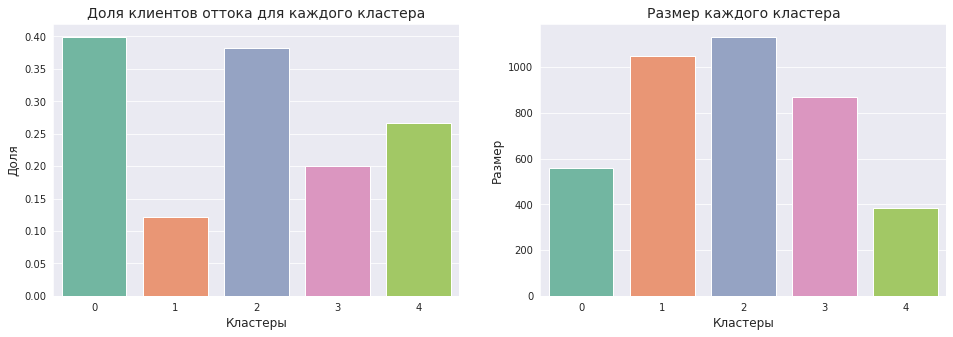

In [29]:
plt.figure(figsize=(16, 5))

sns.set_style('darkgrid')

plt.subplot(1, 2, 1)
plt.title('Доля клиентов оттока для каждого кластера', fontsize=14)
sns.barplot(x='clusters', y='churn_ratio', data=churn_feature, palette='Set2')
plt.xlabel('Кластеры', fontsize=12)
plt.ylabel('Доля', fontsize=12)

plt.subplot(1, 2, 2)
plt.title('Размер каждого кластера', fontsize=14)
sns.barplot(x='clusters', y='churn_size', data=churn_feature, palette='Set2')
plt.xlabel('Кластеры', fontsize=12)
plt.ylabel('Размер', fontsize=12)

plt.show()

Получаем, что для кластеров 1 и 3, на которых уже делался акцент, доля оттока самая меньшая, причем значительно, а между собой наименьшая у кластера 1. При этом по размеру кластер 1 немного усптупает второму, кластер 3 на третьем месте по счету.

## Итоговый вывод

На основе полученного результат исследования можно сделать определенные рекомендации. Так как мы выяснили что наиболее устойчивые и надежные клиенты находятся в кластерах 1 и 3, то дадим рекомендации на основе характерных значений признаков именно для клиентов этих кластеров (по таблице средних значений признаков), а именно:

 - Стоит делать больший упор на клиентов, которые живут рядом с фитнесцентром, а также на тех, кто работает в компании партнере фитнес центра, возможно сделать для них дополнительные акции или привлекательные условия.
 - Так как те клиенты, которые покупают более длительный абонемент и держаться дольше, то стоит сделать более привлекательные условия годовых и полугодовых абонементов.
 - Клиенты из кластера с наименьшей долей оттока чаще других посещают групповые занятия и делают намного больше дополнительных покупок, значит стоит улучшать эти подразделения фитнесклуба.
 - Важно "удерживать" клиентов как можно дольше, в частности по крайней мере 2-3 месяца и стимулировать высокую частоту посещений, хотя бы 2 раза в неделю. Такие клиенты будут жить дольше и приносить больше прибыли в дополнительных услугах. Так как таких клиентов по количеству больше (1 и 3 кластеры в сумме), то стоит работать на взаимодействие именно с ними, а не тратить много ресурсов на новых клиентов в самом начале их взаимодействия с фитнесклубом.
 
Таким образом, можно сделать вывод о том, что основными индикаторами оттока служат:

 - Тот факт, что клиент живет не в районе фитнесцентра
 - Тот факт, что клиент покупает краткосрочный абонемент и посещает спортзал в среднем не более 1 раза в неделю
 - Тот факт, что клиент не посещает групповые занятия, мало покупает дополнительных услуг фитнес центра.
 - В меньшей степени влияет тот факт, что клиент не работает в компании партнере фитнесцентра.